In [5]:
from binance.client import Client
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import numpy as np
import talib

In [3]:
api_key = "8AiGAyxlhYQaRpE1s7097hx5sZ12Ogtr8ir9DsyztaD5j24LrI0fEoToDzCI5lle"
api_secret = "VhudTs0HsBVFNdSTghmqfCjUuIXF6rFiXIfROxHIaM71TGgib7NeZ5aOsJUHjI9f"

In [6]:
client = Client(api_key=api_key, api_secret=api_secret)

In [8]:
def get_history(symbol, interval, start=None, end=None):
    if not start:
        start = "1900-01-01"  # Just random old time for maximum candles
    bars = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end, limit=1000)
    
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit="ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number Of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace=True)

    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")
    return df

In [10]:
def update_btcfile(interval="1m"):
    df = get_history("BTCUSDT", interval, "10-01-01")
    df.to_csv("test_min.csv")
#     df = pd.read_csv("test.csv", parse_dates=["Date"], index_col="Date")
update_btcfile()

In [16]:
class strategy_tester():
    def __init__(self, filepath, units=1, tc=0.1):
        self.filepath = filepath
        self.units = units
        self.tc = tc

    def get_data(self):
        self.data = pd.read_csv("test.csv", parse_dates=["Date"], index_col="Date")
        
    def prepare_data(self, sma1, sma2):
        df = self.data.copy()
        df["returns"] = np.log(df.Close.div(df.Close.shift(1)))
        df["sma1"] = df.Close.rolling(sma1).mean()
        df["sma2"] = df.Close.rolling(sma2).mean()
#         df["rsi"] = talib.RSI(df.Close, 14)
#         condition = (df.sma1 > df.sma2) & (df.rsi < rsi)
        condition = df.sma1 > df.sma2
    
        df["position"] = 0
        df.loc[condition, "position"] = 1
    
        self.data = df
    
    def run_backtest(self):
        df = self.data.copy()
        df["strategy"] = df.returns * df.position.shift(1)
        df["trades"] = df.position.diff().fillna(0).abs()  # To calculate fees and shit
        df.strategy = df.strategy + (df.trades * self.tc)  # Calculate fees and shit
        print(df.trades * self.tc)
        df["creturns"] = df.returns.cumsum().apply(np.exp)
        df["cstrategy"] = df.strategy.cumsum().apply(np.exp)
        self.data = df.copy()
        
    def test_strategy(self, sma1, sma2):
        self.get_data()
        df = self.data
        self.prepare_data(sma1, sma2)
        self.run_backtest()
        
    def optimize_strategy(self, sma1r, sma2r):
        self.datas = []
        performance = []
        combinations = list(product(sma1r, sma2r))
        for comb in combinations:
            self.test_strategy(comb[0], comb[1])
#             self.datas.append(self.data)
            performance.append(self.calc_creturn(self.data))
        self.results_overview =  pd.DataFrame(data=np.array(combinations), columns=["sma1", "sma2"])
        self.results_overview["cstrategy"] = performance
        
    def calc_creturn(self, series):
        return float(series[["strategy"]].sum().apply(np.exp))

In [13]:
df = pd.read_csv("test_min.csv", parse_dates=["Date"], index_col="Date")
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2022-11-19 16:18:00,16653.34,16654.02,16649.33,16650.50,51.259330
2022-11-19 16:19:00,16650.57,16655.09,16650.22,16652.68,51.113220
2022-11-19 16:20:00,16652.35,16653.75,16651.26,16651.26,21.105880


In [25]:
tester = strategy_tester("test_min.csv", tc=-0.0001)

In [26]:
tester.test_strategy(7 ,20)

Date
2017-08-17 04:00:00   -0.0000
2017-08-17 05:00:00   -0.0000
2017-08-17 06:00:00   -0.0000
2017-08-17 07:00:00   -0.0000
2017-08-17 08:00:00   -0.0000
                        ...  
2022-11-19 11:00:00   -0.0000
2022-11-19 12:00:00   -0.0000
2022-11-19 13:00:00   -0.0001
2022-11-19 14:00:00   -0.0000
2022-11-19 15:00:00   -0.0000
Name: trades, Length: 45965, dtype: float64


<AxesSubplot:xlabel='Date'>

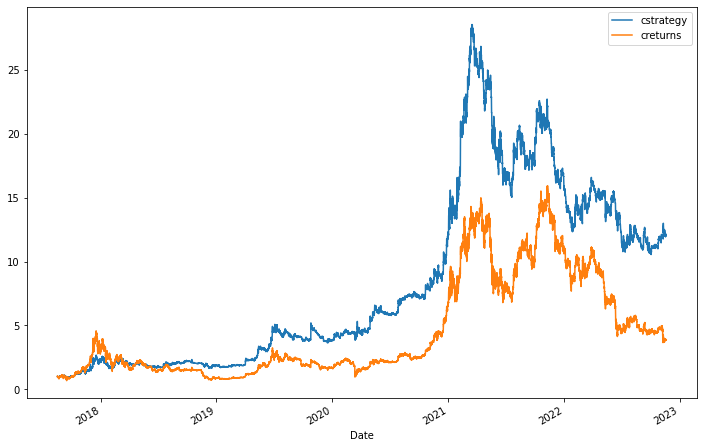

In [27]:
tester.data[["cstrategy", "creturns"]].plot(figsize=(12, 8))

In [28]:
tester.data[["returns", "strategy"]].sum().apply(np.exp)

returns      3.867235
strategy    12.062340
dtype: float64